In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

In [2]:
water = gpd.read_file("waterpoints.geojson")
water.head(3)

,assembly_d,asset_area,asset_id,asset_leng,asset_type,asset_widt,asset_x_co,asset_y_co,bbl,borough,...,row_onsite,secondary_,sewer_type,status,status_gro,tree_commo,tree_latin,NYC_Water_Cluster,color,geometry
0,32.0,85.0,94002.0,17.0,ROWB,5.0,1.036475e+06,191223.22700,4.095890e+09,Queens,...,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,Chinese Fringetree,Chionanthus retusus,1,#00ff00,POINT (-73.81168 40.69139)
1,32.0,45.5,94012.0,13.0,ROWGS,3.5,1.036305e+06,191586.59230,4.095020e+09,Queens,...,ROW,4.095020e+09,Combined,Constructed (Full Maintenance),Constructed,N/A,No Tree,1,#00ff00,POINT (-73.81229 40.69238)
2,32.0,70.0,94017.0,20.0,ROWGS,3.5,1.036319e+06,191856.45894,4.095030e+09,Queens,...,ROW,0.000000e+00,Combined,Constructed (Full Maintenance),Constructed,N/A,No Tree,1,#00ff00,POINT (-73.81223 40.69313)


In [9]:
print(water.columns)

Index(['assembly_d', 'asset_area', 'asset_id', 'asset_leng', 'asset_type',
       'asset_widt', 'asset_x_co', 'asset_y_co', 'bbl', 'borough',
       'city_counc', 'community_', 'construc_1', 'constructi', 'dep_cont_1',
       'dep_contra', 'gi_feature', 'gi_id', 'nyc_waters', 'outfall',
       'program_ar', 'project_na', 'row_onsite', 'secondary_', 'sewer_type',
       'status', 'status_gro', 'tree_commo', 'tree_latin', 'NYC_Water_Cluster',
       'color', 'geometry'],
      dtype='object')


In [3]:
neighborhood_gdf = gpd.read_file("2010 Neighborhood Tabulation Areas (NTAs).geojson")
neighborhood_gdf.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ..."


In [5]:
cmap = {
    "East River / Open Waters": "#ff0000",
    "Jamaica Bay and Tributaries": "#00ff00",
    "Flushing Creek": "#0000ff",
    "Newtown Creek": "#ff00ff",
    "Gowanus Canal": "#00ffff",
    "Bronx River": "#ffff00",
    "Hutchinson River": "#808080",
    "Flushing Bay": "#800000",
    "Westchester Creek": "#008000",
    "Coney Island Creek": "#000080",
    "Alley Creek": "#800080",
    "Unknown": "#000000",
}

water["color"] = water["nyc_waters"].map(cmap)

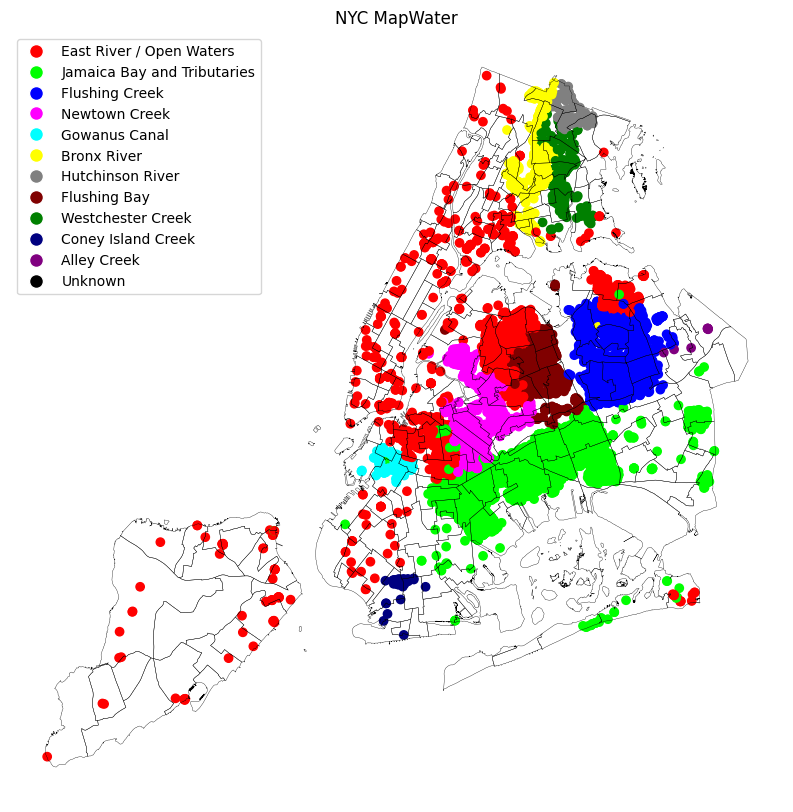

In [8]:

fig, ax = plt.subplots(figsize=(10, 10))

# Plot water data
water.plot(ax=ax, color=water["color"], legend=True)

# Plot neighborhood data
neighborhood_gdf.plot(ax=ax, color="none", edgecolor="black", linewidth=0.25)

# Turn off the axis
ax.set_axis_off()

# Add title
plt.title("NYC MapWater")

# Create custom legend
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

# Show plot
plt.show()


/opt/anaconda3/envs/CDP/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


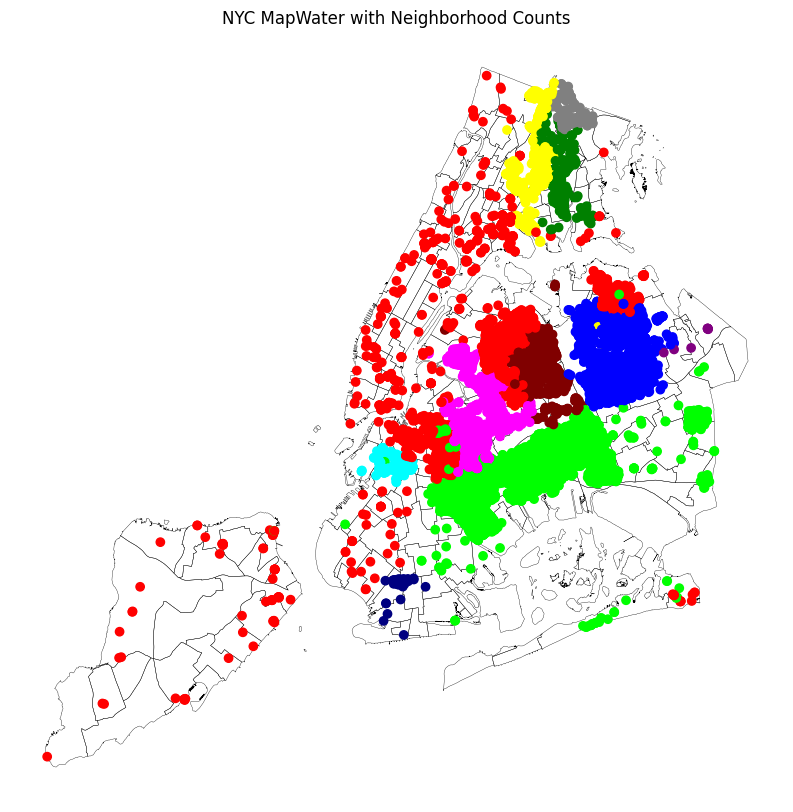

                                             ntaname  total_points  \
0                                         St. Albans           2.0   
1                                           Canarsie         662.0   
2                                         Mount Hope           NaN   
3                                        Fort Greene          26.0   
4                 Pomonok-Flushing Heights-Hillcrest         177.0   
..                                               ...           ...   
190                                    Rikers Island           NaN   
191                      park-cemetery-etc-Manhattan          12.0   
192                         park-cemetery-etc-Queens          76.0   
193  Soundview-Castle Hill-Clason Point-Harding Park          28.0   
194                                    College Point           6.0   

        most_dominant_nyc_waters  
0    Jamaica Bay and Tributaries  
1    Jamaica Bay and Tributaries  
2                            NaN  
3       East River 

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Assuming water and neighborhood_gdf are already defined
# water = gpd.read_file('path_to_water_shapefile')
# neighborhood_gdf = gpd.read_file('path_to_neighborhood_shapefile')

# Perform a spatial join to assign each water point to a neighborhood
water_in_neighborhoods = gpd.sjoin(water, neighborhood_gdf, how='left', op='within')

# Group by the neighborhood identifier (e.g., neighborhood name or ID)
grouped = water_in_neighborhoods.groupby('ntaname')

# Aggregate the counts and determine the most dominant 'nyc_waters' value
result = grouped['nyc_waters'].agg([
    ('total_points', 'count'),
    ('most_dominant_nyc_waters', lambda x: x.value_counts().idxmax())
]).reset_index()

# Merge the result back with neighborhood_gdf
neighborhood_with_counts = neighborhood_gdf.merge(result, on='ntaname', how='left')

# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
neighborhood_with_counts.plot(ax=ax, color="none", edgecolor="black", linewidth=0.25)
water.plot(ax=ax, color=water["color"], legend=True)
ax.set_axis_off()
plt.title("NYC MapWater with Neighborhood Counts")

# Show plot
plt.show()

# Print result
print(neighborhood_with_counts[['ntaname', 'total_points', 'most_dominant_nyc_waters']])


In [11]:
neighborhood_with_counts.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,total_points,most_dominant_nyc_waters
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",2.0,Jamaica Bay and Tributaries
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",662.0,Jamaica Bay and Tributaries
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",NaN,NaN


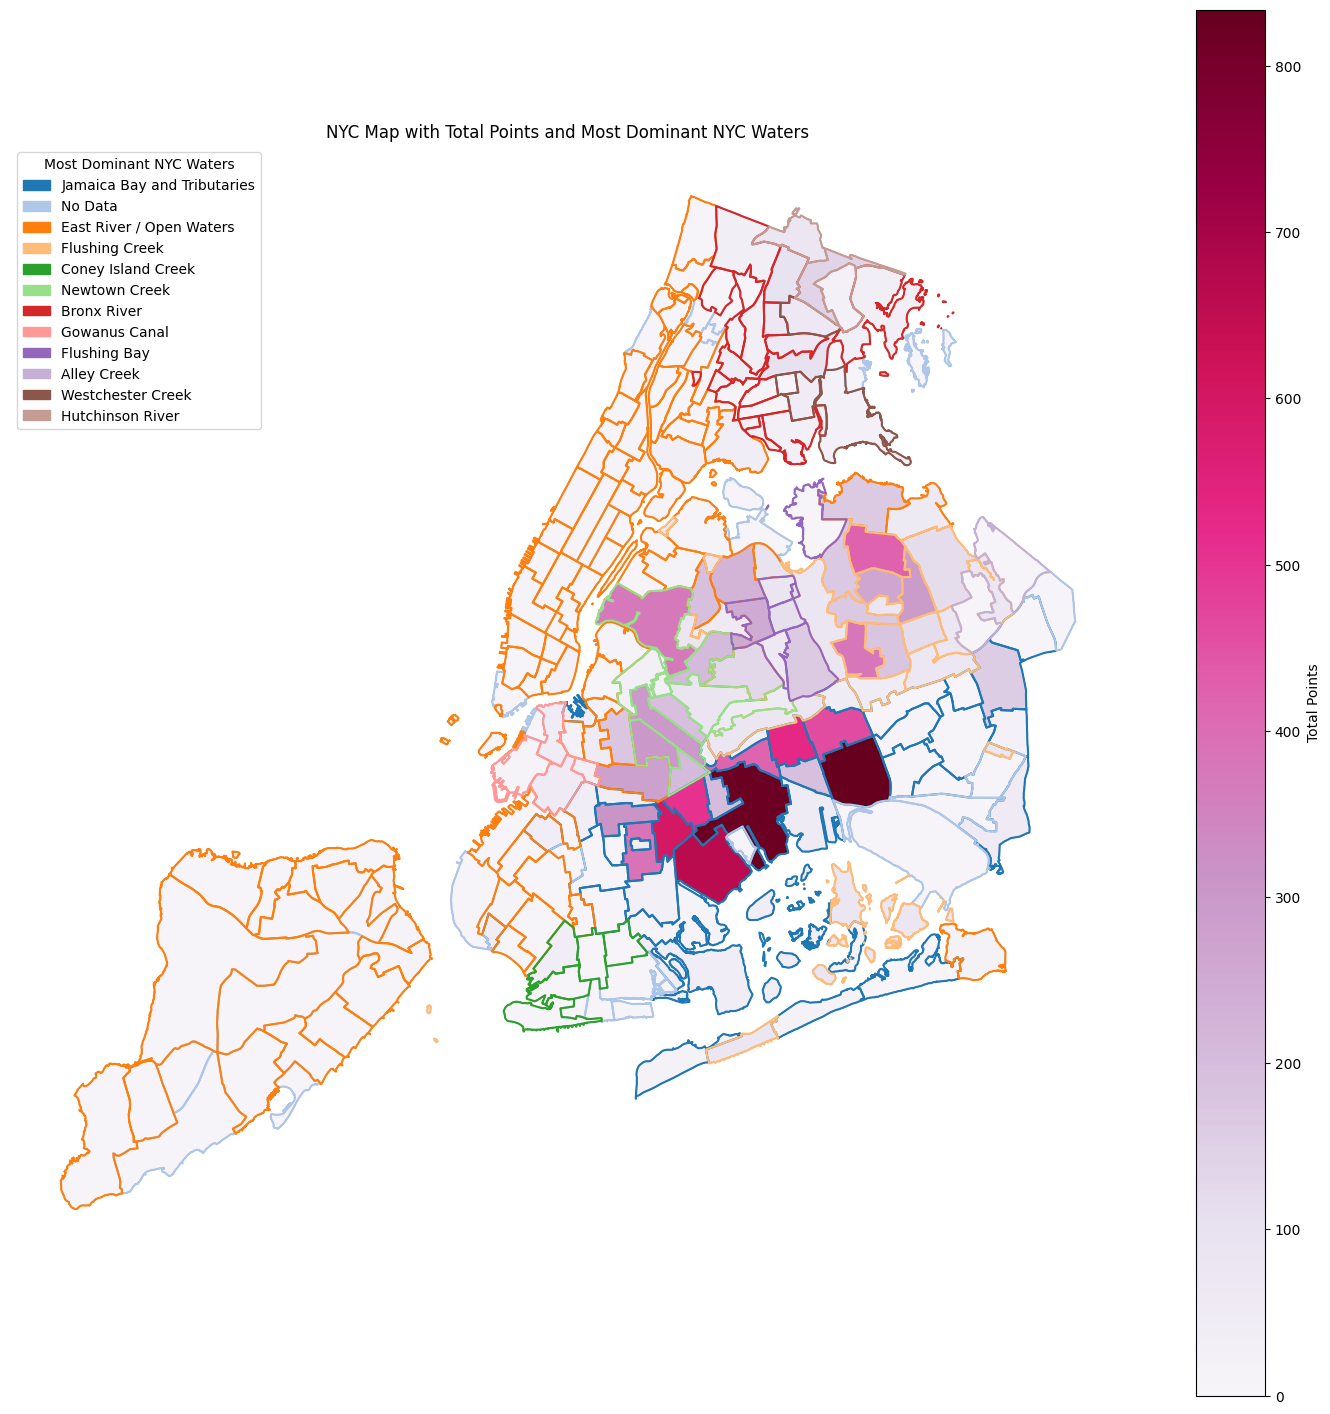

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Assuming neighborhood_with_counts is already defined

# Fill NaN values in 'total_points' with 0
neighborhood_with_counts['total_points'] = neighborhood_with_counts['total_points'].fillna(0)

# Handle NaN values in 'most_dominant_nyc_waters' if necessary
# For example, fill with a placeholder string or skip NaN values
neighborhood_with_counts['most_dominant_nyc_waters'] = neighborhood_with_counts['most_dominant_nyc_waters'].fillna('No Data')

# Create a colormap for the total_points choropleth
cmap = plt.cm.PuRd
norm = plt.Normalize(vmin=neighborhood_with_counts['total_points'].min(), vmax=neighborhood_with_counts['total_points'].max())

# Create a color mapping for the 'most_dominant_nyc_waters' values
unique_nyc_waters = neighborhood_with_counts['most_dominant_nyc_waters'].unique()
colors = plt.cm.tab20.colors[:len(unique_nyc_waters)]
color_dict = dict(zip(unique_nyc_waters, colors))

# Plot the neighborhoods with a choropleth based on 'total_points'
fig, ax = plt.subplots(figsize=(18, 18))
neighborhood_with_counts.plot(column='total_points', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.25')

# Overlay the neighborhoods with different colors based on 'most_dominant_nyc_waters'
for key, value in color_dict.items():
    neighborhood_with_counts[neighborhood_with_counts['most_dominant_nyc_waters'] == key].boundary.plot(ax=ax, linewidth=1.5, edgecolor=value)

# Add a colorbar for the choropleth
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Total Points')

# Create custom legends for 'most_dominant_nyc_waters'
patches = [mpatches.Patch(color=color_dict[dom], label=dom) for dom in color_dict]
plt.legend(handles=patches, loc='upper left', title='Most Dominant NYC Waters')

# Turn off the axis
ax.set_axis_off()

# Add title
plt.title("NYC Map with Total Points and Most Dominant NYC Waters")

# Show plot
plt.show()


Maps up to this point were somewhat helpful but were not so clear in displaying intent of this data set.  Now that the vector map of NYC is overlaid, we can infer that excess water drainage system is densely located in areas that demarcate intensity of colors according to the color bar.  So according to above map, Jamaica Bay, Flushing Creek, and Newton Creek have the most excess waters draining out from the nearby neighborhoods. Therefore, it is useful in determining flooding risks. 